## BẢNG PHÂN CÔNG

| MSSV     | Họ và tên        | % đóng góp (tối đa 100%) | Chi   tiết công việc         |
|----------|------------------|--------------------------|------------------------------|
| 19120511 | Võ Văn Hiếu      | 100                      | ...                          |
| 19120526 | Huỳnh Đức Huy    | 100                      | ...                          |
| 19120539 | Vương Thế Khang  | 100                      | ...                          |
| 19120554 | Lê Kiệt          | 100                      | ...                          |
| 19120586 | Nguyễn Phát Minh | 100                      | ...                          |

# THƯ VIỆN

In [20]:
import pandas as pd
import numpy as np
import re
import joblib
import requests
import matplotlib.pyplot as plt

from underthesea import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# KHÁM PHÁ DỮ LIỆU

Đọc dữ liệu từ file "vn_news_223_tdlft.csv" và lưu vào dataframe `news_df`.

In [21]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv')
news_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
news_df.shape

(223, 3)

Vậy dữ liệu có kích thước **223 dòng x 3 cột**

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin về một bài báo, có vẻ như không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

Kiểm tra xem dữ liệu có các dòng bị lặp không và lưu kết quả vào biến `have_duplicated_row`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược lại.

In [6]:
have_duplicated_row = all(news_df.duplicated())
have_duplicated_row

False

Như vậy, không có dòng nào bị lặp lại.

### Mỗi cột có ý nghĩa gì?

Thông tin về các cột như sau:
- **text:** nội dung của bài báo
- **domain:** tên miền (website)
- **label:** nhãn (1: tin thật, 0: tin giả)

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Xem thử kiểu dữ liệu của các cột dữ liệu

In [8]:
news_df.dtypes

text      object
domain    object
label      int64
dtype: object

Có vẻ các cột đều có kiểu dữ liệu phù hợp. Nếu trong quá trình phân tích dữ liệu cần phải thay đổi kiểu dữ liệu của các cột thì ta sẽ quay lại tiền xử lý ở đây, tạm thời ta chấp nhận kiểu dữ liệu hiện tại của các cột.

### Kiểm tra phân bố các lớp/nhãn

Plot cột `label` thành 2 bar, mỗi bar là freq của 1 hoặc 0.

<AxesSubplot:xlabel='label', ylabel='frequency'>

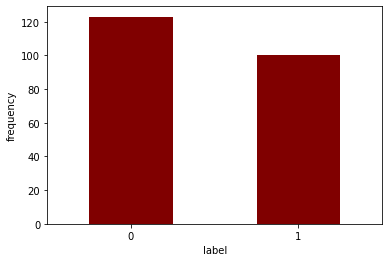

In [13]:
news_df['label'].value_counts().plot.bar(xlabel = 'label', ylabel = 'frequency', rot = 0, color = 'maroon')

### Các thông tin thống kê của văn bản

Các thông tin thống kê bao gồm:
- Chiều dài trung bình của mỗi record.
- ...

In [14]:
print('Chiều dài trung bình của các text:', news_df['text'].apply(len).mean())

Chiều dài trung bình của các text: 2539.7713004484303


# TIỀN XỬ LÝ DỮ LIỆU

Ở phần này, ta tiền xử lý văn bản cho cột `text`. Các bước xử lý:
- Bước 1: loại bỏ các đường dẫn
- Bước 2: loại bỏ ký tự đặc biệt (@,#, /,!.\'+-= và \n)
- Bước 3: tokenize (sử dụng thư viện **underthesea**)
- Bước 4: loại bỏ stopwords (Link stopwords: https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

In [15]:
# Lấy danh sách stopwords
stopwords_raw_url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
stopwords = requests.get(stopwords_raw_url).text.split('\n')

In [16]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv')
news_df.head()


,text,domain,label,text_reduced
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,"[Thủ tướng, Abe, cúi, đầu, xin lỗi, hành động,..."
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,"[Thủ tướng, Nhật, cúi, đầu, xin lỗi, tinh thần..."
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,"[Choáng, Cơ trưởng, đeo, khăn quàng, quẩy, ban..."
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,"[Chưa, nhạc, Kpop, hát, Giáo sư, Nguyễn Lân Dũ..."
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,"[Đại học, Hutech, áp dụng, cải cách, Tiếq Việt..."


# MÔ HÌNH HÓA DỮ LIỆU

<AxesSubplot:xlabel='label', ylabel='frequency'>

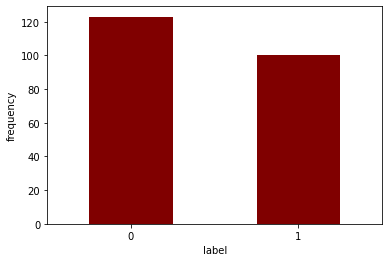

In [22]:
news_df['label'].value_counts().plot.bar(xlabel = 'label', ylabel = 'frequency', rot = 0, color = 'maroon')

Trước khi mô hình hóa dữ liệu, ta sẽ tách `news_df` thành tập huấn luyện (X_train) và tập validation (y_train):
- Tập huấn luyện ta sẽ lấy mỗi cột `text_reduced`.
- Tập validation ta sẽ lấy cột `label`.

In [23]:
print('Chiều dài trung bình của các text:', news_df['text'].apply(len).mean())

Chiều dài trung bình của các text: 2554.57399103139


X_train = news_df['text_reduced'].str.join(' ')
y_train = news_df['label']

Ở phần này, ta tiền xử lý văn bản cho cột `text`. Các bước xử lý:
- Bước 1: loại bỏ các đường dẫn
- Bước 2: loại bỏ ký tự đặc biệt (@,#, /,!.\'+-= và \n)
- Bước 3: tokenize (sử dụng Under The Sea)
- Bước 4: loại bỏ stopwords (Link stopwords: https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

In [24]:
class TextReducer(BaseEstimator, TransformerMixin):
    stopwords_raw_url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"

    def __init__(self):
        self.stopwords = requests.get(self.stopwords_raw_url).text.split('\n')

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        _X = pd.Series(X)

        _X = _X.apply(lambda text: re.sub(r'http(s?)\S+.', '', text))
        _X = _X.apply(lambda text: re.sub(r'[@#/!.\'‘’\"“”–+-=()%]', '', text))
        _X = _X.apply(lambda text: re.sub(r'\r\n', ' ', text))
        _X = _X.apply(lambda text: text.lower())
        _X = _X.apply(word_tokenize)
        _X = _X.apply(lambda words: ' '.join([word for word in words if word not in self.stopwords]))

        return _X

In [34]:
# III. Mô hình hóa

Predict:  Fake


In [25]:
def generate_models(preprocessors, vectorizers, classifiers, X_train, y_train, out):
    for p in preprocessors:
        for v in vectorizers:
            for c in classifiers:
                pipeline = Pipeline([('text_reducer', preprocessors[p]),
                                     ('vectorizer'  , vectorizers[v]),
                                     ('classifier'  , classifiers[c])])
                pipeline.fit(X_train, y_train)
                filepath = out.rstrip('\\').rstrip('/') + '/' + p + '_' + v + '_' + c + '.pkl'
                joblib.dump(pipeline, filepath, compress = 1)

Predict:  Real


In [27]:
preprocessors = {'tr':TextReducer()}

vectorizers = {'cv':CountVectorizer(), 
               'tv':TfidfVectorizer()}

classifiers = {'li':LinearRegression(), 
               'lo':LogisticRegression(random_state=42), 
               'dt':DecisionTreeClassifier(random_state=42), 
               'rf':RandomForestClassifier(random_state=42)}

X_train = news_df['text']
y_train = news_df['label']

generate_models(preprocessors, vectorizers, classifiers, X_train, y_train, 'models')

# IV. Deploy mô hình

- Phần này sử dụng thư viện Streamlit và làm trong file `app.py`